In [1]:
import torch
import numpy as np
import renormalize, paintwidget, labwidget, show
import time
import cv2
from PIL import Image
from torchvision import transforms

In [2]:
def reprojection(uv_A, z_A, c2w_A, c2w_B, K):
    """
    Args
        uvs_A: of shape (n_uvs, 2) 
    """
    pt_z_A = z_A[uv_A[1], uv_A[0]][None, :, None]  # (1, n_depths, 1)
    n_depths = pt_z_A.shape[1]
    xyz_A_camera = (np.stack([uv_A[0], uv_A[1], 1])[None, None, :] * pt_z_A) @ np.linalg.inv(K).T
    # xyz_A_camera has shape (1, n_depths, 3).
    
    xyz_A_world = np.concatenate([xyz_A_camera, np.ones([1, n_depths, 1])], axis=2) @ c2w_A.T
    # xyz_A_world has shape (1, n_depths, 4).
    uvs_B = (xyz_A_world @ np.linalg.inv(c2w_B).T)[:, :, :3] @ K.T
    uvs_B = (uvs_B[:, :, :2] / uvs_B[:, :, 2:]).astype(np.int32)
    return uvs_B


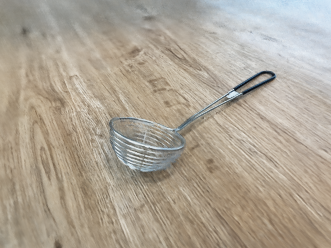
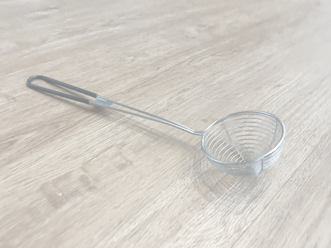
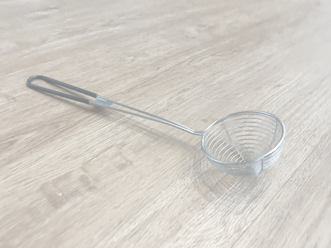

In [3]:
src_img = Image.open('/home/yenchenl/Workspace/DSNeRF/logs/strainer-360/renderonly_train_199999/rgb/000.png')
tgt_img = Image.open('/home/yenchenl/Workspace/DSNeRF/logs/strainer-360/renderonly_train_199999/rgb/015.png')
src_z = np.load('/home/yenchenl/Workspace/DSNeRF/logs/strainer-360/renderonly_train_199999/z/000.npy')
tgt_z = np.load('/home/yenchenl/Workspace/DSNeRF/logs/strainer-360/renderonly_train_199999/z/015.npy')
src_weight = np.load('/home/yenchenl/Workspace/DSNeRF/logs/strainer-360/renderonly_train_199999/weight/000.npy')
tgt_weight = np.load('/home/yenchenl/Workspace/DSNeRF/logs/strainer-360/renderonly_train_199999/weight/015.npy')
src_c2w = np.load('/home/yenchenl/Workspace/DSNeRF/logs/strainer-360/renderonly_train_199999/c2w/000.npy')
tgt_c2w = np.load('/home/yenchenl/Workspace/DSNeRF/logs/strainer-360/renderonly_train_199999/c2w/015.npy')
K = np.load('/home/yenchenl/Workspace/DSNeRF/logs/strainer-360/renderonly_train_199999/intrinsics.npy')

W, H = src_img.size
src_img_tensor = transforms.ToTensor()(src_img)
tgt_img_tensor = transforms.ToTensor()(tgt_img)

src_painter = paintwidget.PaintWidget(
    oneshot=False, width=W, height=H, 
    brushsize=1, save_sequence=False, track_move=True) # , on_move=True)
src_painter.image = renormalize.as_url(src_img_tensor, source='pt')
img_url = renormalize.as_url(tgt_img_tensor, source='pt')
img_html = '<img src="%s"/>'%img_url
output_div = labwidget.Div(img_html)

counter = 0
prev_time = time.time()
update_freq = 0.5 # mouse time intervals;  
# decrease update_freq to reduce lagging, but colab is kind of slow

def probe_changed(c):
    global counter
    global prev_time
    counter += 1
    curr_time = time.time()
    if curr_time - prev_time < update_freq:
        return
    prev_time = time.time()
    
    u_A = int(src_painter.px)
    v_A = int(src_painter.py)
    uvs_B = reprojection([u_A, v_A], src_z, src_c2w, tgt_c2w, K)
    
    img_A_draw = np.array(src_img).copy()
    img_B_draw = np.array(tgt_img).copy()
    for idx_pt in range(uvs_B.shape[0]):
        color = tuple((255*np.random.rand(3)).tolist())
        img_A_draw = cv2.circle(img_A_draw, tuple([u_A, v_A]), 3, color, -1)
        img_url = renormalize.as_url(
            transforms.ToTensor()(img_A_draw)
        )
        src_painter.image = img_url
        
        for idx_depth in range(uvs_B.shape[1]):
            img_B_overlay = img_B_draw.copy()
            img_B_overlay = cv2.circle(img_B_overlay, tuple(uvs_B[idx_pt][idx_depth]), 3, color, -1)
            alpha = src_weight[v_A, u_A][idx_depth] * 10
            img_B_draw = cv2.addWeighted(img_B_overlay, alpha, img_B_draw, 1 - alpha, 0)
    img_url = renormalize.as_url(
        transforms.ToTensor()(img_B_draw)
    )
    img_html = '<img src="%s"/>'%img_url
    output_div.innerHTML = img_html
    
src_painter.on('mask_buffer', probe_changed)

show.a([src_painter], cols=2)
show.a([output_div], cols=2)

show.flush()

In [4]:
tgt_c2w.shape

(4, 4)